# CfMM Database Schema Check

In [1]:
# Import libraries
import sqlite3
import pandas as pd

# Set pandas params
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

## Initialize db connections

In [2]:
db_path = 'cfmm_db.db'
conn = sqlite3.connect(db_path)

## What tables are inside CfMM db?

In [3]:
sql_query = "SELECT name AS table_name, type FROM sqlite_master WHERE type='table'"
schema_df = pd.read_sql_query(sql_query, conn)
schema_df

,table_name,type
0,sqlite_sequence,table
1,users,table
2,articles,table
3,article_analyses,table
4,analysis_revisions,table
5,cfmm_db_data,table
6,topic_list,table
7,processed_articles,table


## Parsing Table Contents, Keys and Data Types

In [4]:
import sqlite3
import pandas as pd

def profile_database(db_path):
    """
    Profiles the SQLite database to gather schema information for ERD creation.
    
    Args:
        db_path (str): Path to the SQLite database.
    
    Returns:
        dict: A dictionary containing schema details (tables, columns, and relationships).
    """
    # Connect to the database
    conn = sqlite3.connect(db_path)
    schema_info = {}

    # Get all table names
    tables_query = "SELECT name FROM sqlite_master WHERE type='table';"
    tables = pd.read_sql_query(tables_query, conn)['name'].tolist()

    for table in tables:
        # Get column information for each table
        schema_info[table] = {'columns': [], 'foreign_keys': []}
        pragma_query = f"PRAGMA table_info({table});"
        columns = pd.read_sql_query(pragma_query, conn)
        for _, row in columns.iterrows():
            schema_info[table]['columns'].append({
                'name': row['name'],
                'type': row['type'],
                'not_null': bool(row['notnull']),
                'default': row['dflt_value'],
                'primary_key': bool(row['pk']),
            })

        # Get foreign key relationships for each table
        pragma_foreign_query = f"PRAGMA foreign_key_list({table});"
        foreign_keys = pd.read_sql_query(pragma_foreign_query, conn)
        for _, fk_row in foreign_keys.iterrows():
            schema_info[table]['foreign_keys'].append({
                'from_column': fk_row['from'],
                'to_table': fk_row['table'],
                'to_column': fk_row['to'],
            })

    conn.close()
    return schema_info

def generate_lucidchart_erd(schema_info):
    """
    Generates Lucidchart-compatible schema information for creating an ERD.
    
    Args:
        schema_info (dict): Database schema details.
    """
    print("Tables and Columns:")
    for table, details in schema_info.items():
        print(f"Table: {table}")
        for column in details['columns']:
            pk = " (PK)" if column['primary_key'] else ""
            print(f"  - {column['name']} ({column['type']}){pk}")

        if details['foreign_keys']:
            print("  Foreign Keys:")
            for fk in details['foreign_keys']:
                print(f"    - {fk['from_column']} -> {fk['to_table']}.{fk['to_column']}")
    print("\nUse the above information to create tables, columns, and relationships in Lucidchart.")

# Path to the SQLite database
db_path = 'cfmm_db.db'

# Profile the database
schema_info = profile_database(db_path)

# Generate output for Lucidchart
generate_lucidchart_erd(schema_info)


Tables and Columns:
Table: sqlite_sequence
  - name ()
  - seq ()
Table: users
  - user_id (INTEGER) (PK)
  - email (VARCHAR(255))
  - password_hash (VARCHAR(255))
  - full_name (VARCHAR(100))
  - created_at (DATETIME)
  - last_login (DATETIME)
  - is_active (BOOLEAN)
  - role (VARCHAR(50))
Table: articles
  - article_id (INTEGER) (PK)
  - publish_date (DATE)
  - url (TEXT)
  - publisher (VARCHAR(255))
  - headline (TEXT)
  - article_text (TEXT)
  - created_at (DATETIME)
  - created_by (INTEGER)
  - location (VARCHAR(255))
  Foreign Keys:
    - created_by -> users.user_id
Table: article_analyses
  - analysis_id (INTEGER) (PK)
  - article_id (INTEGER)
  - negative_aspects (VARCHAR(20))
  - negative_aspects_analysis (TEXT)
  - generalization (VARCHAR(20))
  - generalization_analysis (TEXT)
  - omit_due_prominence (VARCHAR(20))
  - omit_due_prominence_analysis (TEXT)
  - headline_bias (VARCHAR(20))
  - headline_bias_analysis (TEXT)
  - misrepresentation (VARCHAR(20))
  - misrepresentation

## Table Preview

### 1. `users` Table

In [5]:
sql_query = "SELECT * FROM users"
pd.read_sql_query(sql_query, conn).head()

,user_id,email,password_hash,full_name,created_at,last_login,is_active,role
0,1,admin@example.com,temporary_hash,Admin User,2025-01-12 14:16:38,None,1,analyst


### 2. `articles` Table

In [6]:
sql_query = "SELECT * FROM articles"
pd.read_sql_query(sql_query, conn).head()

,article_id,publish_date,url,publisher,headline,article_text,created_at,created_by,location
0,1,7/2/2024,https://www.itv.com/news/2019-03-23/sixth-birm...,ITV News,Sixth Birmingham mosque targeted by vandals,Another Birmingham mosque has been targeted by...,2025-01-12 14:17:12,1,None
1,2,7/2/2024,https://www.thetimes.co.uk/article/women-s-rig...,The Times,Women's rights activist 'tortured in Saudi jail',Riyadh A key campaigner for the right of women...,2025-01-12 14:17:12,1,Saudi Arabia
2,3,7/2/2024,https://www.dailymail.co.uk/news/article-71381...,Daily Mail,Vandals spray paint famous mural dedicated to ...,Vandals have defaced a famous mural in Kentuck...,2025-01-12 14:17:12,1,None
3,4,7/2/2024,https://www.bbc.co.uk/news/world-europe-47957010,BBC News,Spanish far-right Vox party banned from TV debate,Spain's election board has banned the far-righ...,2025-01-12 14:17:12,1,Spain
4,5,7/3/2024,https://www.thesun.co.uk/news/8683239/isis-wil...,The Sun,Donald Trump says US forces 'killed terrorists...,DONALD Trump says US forces have killed the IS...,2025-01-12 14:17:12,1,Syrian Arab Republic


### 3. `topic_list` Table

In [7]:
sql_query = "SELECT * FROM topic_list"
pd.read_sql_query(sql_query, conn).head()

,topic_list_id,article_id,topic_name
0,1,2,Crimes and Arrests
1,2,4,Politics
2,3,5,Terrorism and Extremism
3,4,6,Health
4,5,7,Terrorism and Extremism


### 4. `article_analyses` Table

In [8]:
sql_query = "SELECT * FROM article_analyses"
pd.read_sql_query(sql_query, conn).head()

,analysis_id,article_id,negative_aspects,negative_aspects_analysis,generalization,generalization_analysis,omit_due_prominence,omit_due_prominence_analysis,headline_bias,headline_bias_analysis,misrepresentation,misrepresentation_analysis,overall_rating,created_at,created_by,is_current
0,1,1,Very Low,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,Not Biased,2025-01-12 14:17:46,1,1
1,2,2,Low,# Executive Summary\nThe article contains seve...,NA,# Executive Summary\nThe article contains seve...,Low,# Executive Summary\nThe article contains seve...,NA,# Executive Summary\nThe article contains seve...,Low,# Executive Summary\nThe article contains seve...,Not Biased,2025-01-12 14:17:46,1,1
2,3,3,Medium,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,Low,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,NA,# Executive Summary\nThe article reports on va...,Not Biased,2025-01-12 14:17:46,1,1
3,4,4,NA,# Executive Summary\nThe article discusses the...,NA,# Executive Summary\nThe article primarily foc...,NA,# Executive Summary\nThe article primarily foc...,NA,# Executive Summary\nThe article primarily foc...,NA,# Executive Summary\nThe article primarily foc...,Not Biased,2025-01-12 14:17:46,1,1
4,5,5,Low,# Executive Summary\nThe article primarily foc...,NA,# Executive Summary\nThe article primarily rep...,Low,# Executive Summary\nThe article primarily rep...,NA,# Executive Summary\nThe article primarily rep...,Low,# Executive Summary\nThe article primarily rep...,Possibly Biased,2025-01-12 14:17:46,1,1


### 5. `analysis_revisions` Table

In [9]:
sql_query = "SELECT * FROM analysis_revisions"
pd.read_sql_query(sql_query, conn).head()

,revision_id,analysis_id,negative_aspects,negative_aspects_analysis,generalization,generalization_analysis,omit_due_prominence,omit_due_prominence_analysis,headline_bias,headline_bias_analysis,misrepresentation,misrepresentation_analysis,overall_rating,revision_note,created_at,created_by,is_current


### 6. `cfmm_db_data` Table

In [10]:
sql_query = "SELECT * FROM cfmm_db_data"
pd.read_sql_query(sql_query, conn).head()

,article_url,date_published,author,title,text,keywords,cfmm_generalization,cfmm_omit,cfmm_ negative,cfmm_misrep,cfmm_headline,cfmm_rating,summary,text_w_headline,article_analysis_NA,article_analysis_2_NA,new_negative,article_analysis,article_analysis_2,new_generalization,new_misrep,new_omit,new_headlines
0,https://www.itv.com/news/2019-03-23/sixth-birm...,7/2/2024,None,Sixth Birmingham mosque targeted by vandals,Another Birmingham mosque has been targeted by...,"mosque,mosques,Mosque,Islamic,Masjid,Madrassa,...",N,N,N,N,NOT MISLEADING,Not Biased,# List of Muslim or Islam Related Passages\n*A...,<headline>Sixth Birmingham mosque targeted by ...,# Executive Summary\nThe article reports on va...,"# Executive Summary\nAfter a thorough recheck,...",Very Low,# Executive Summary\nThe article reports on va...,"# Executive Summary\nAfter a thorough recheck,...",NA,NA,NA,NA
1,https://www.thetimes.co.uk/article/women-s-rig...,7/2/2024,The Times,Women's rights activist 'tortured in Saudi jail',Riyadh A key campaigner for the right of women...,"imam,jihadists,Imam",N,N,Y,N,NOT MISLEADING,Dont Know,# List of Muslim or Islam Related Passages\n*R...,<headline>Women's rights activist 'tortured in...,# Executive Summary\nThe article contains seve...,"# Executive Summary\nUpon reanalysis, the arti...",Low,# Executive Summary\nThe article contains seve...,"# Executive Summary\nUpon reanalysis, the arti...",NA,Low,Low,NA
2,https://www.dailymail.co.uk/news/article-71381...,7/2/2024,By,Vandals spray paint famous mural dedicated to ...,Vandals have defaced a famous mural in Kentuck...,"Islam,Muslims",Y,Y,Y,Y,NOT MISLEADING,Very Biased,# List of Muslim or Islam Related Passages\n*I...,<headline>Vandals spray paint famous mural ded...,# Executive Summary\nThe article reports on va...,"# Executive Summary\nUpon reanalysis, the arti...",Medium,# Executive Summary\nThe article reports on va...,"# Executive Summary\nUpon reanalysis, the arti...",NA,NA,Low,NA
3,https://www.bbc.co.uk/news/world-europe-47957010,7/2/2024,None,Spanish far-right Vox party banned from TV debate,Spain's election board has banned the far-righ...,Islam,N,N,N,N,NOT MISLEADING,Not Biased,# List of Muslim or Islam Related Passages\n*a...,<headline>Spanish far-right Vox party banned f...,# Executive Summary\nThe article discusses the...,"# Executive Summary\nAfter a thorough recheck,...",NA,# Executive Summary\nThe article primarily foc...,"# Executive Summary\nAfter a thorough recheck,...",NA,NA,NA,NA
4,https://www.thesun.co.uk/news/8683239/isis-wil...,7/3/2024,Tariq Tahir,Donald Trump says US forces 'killed terrorists...,DONALD Trump says US forces have killed the IS...,"Islamic,caliphate",N,Y,Y,N,NOT MISLEADING,Possibly Biased,# List of Muslim or Islam Related Passages\n*I...,<headline>Donald Trump says US forces 'killed ...,# Executive Summary\nThe article primarily foc...,"# Executive Summary\nUpon reanalysis, the arti...",Low,# Executive Summary\nThe article primarily rep...,"# Executive Summary\nUpon reanalysis, the arti...",NA,Low,Low,NA


### 7. `processed_articles` Table

In [11]:
sql_query = "SELECT * FROM processed_articles"
pd.read_sql_query(sql_query, conn).head()

,date_published,publisher,title,text,article_url,location,topic_list,topic
0,2025-01-23 02:48:00,ITV News,Sixth Birmingham mosque targeted by vandals,Another Birmingham mosque has been targeted by...,https://www.itv.com/news/2019-03-23/sixth-birm...,None,[],None
1,2025-01-23 02:48:00,The Times,Women's rights activist 'tortured in Saudi jail',Riyadh A key campaigner for the right of women...,https://www.thetimes.co.uk/article/women-s-rig...,Saudi Arabia,"['Crimes and Arrests', ""Women's Rights""]",Crimes and Arrests | Women's Rights
2,2025-01-23 02:48:00,Daily Mail,Vandals spray paint famous mural dedicated to ...,Vandals have defaced a famous mural in Kentuck...,https://www.dailymail.co.uk/news/article-71381...,None,[],None
3,2025-01-23 02:48:00,BBC News,Spanish far-right Vox party banned from TV debate,Spain's election board has banned the far-righ...,https://www.bbc.co.uk/news/world-europe-47957010,Spain,"['Politics', 'Health', 'Immigration', 'Crimes ...",Politics | Health | Immigration | Crimes and A...
4,2025-01-23 02:48:00,The Sun,Donald Trump says US forces 'killed terrorists...,DONALD Trump says US forces have killed the IS...,https://www.thesun.co.uk/news/8683239/isis-wil...,Syrian Arab Republic,"['Terrorism and Extremism', 'Politics', 'Confl...",Terrorism and Extremism | Politics | Conflict ...


## Table Relationships (Draw.io)

https://drive.google.com/file/d/1XHg2jM0RvlqwQocvItVF5FT-VDp0VZoJ/view?usp=sharing

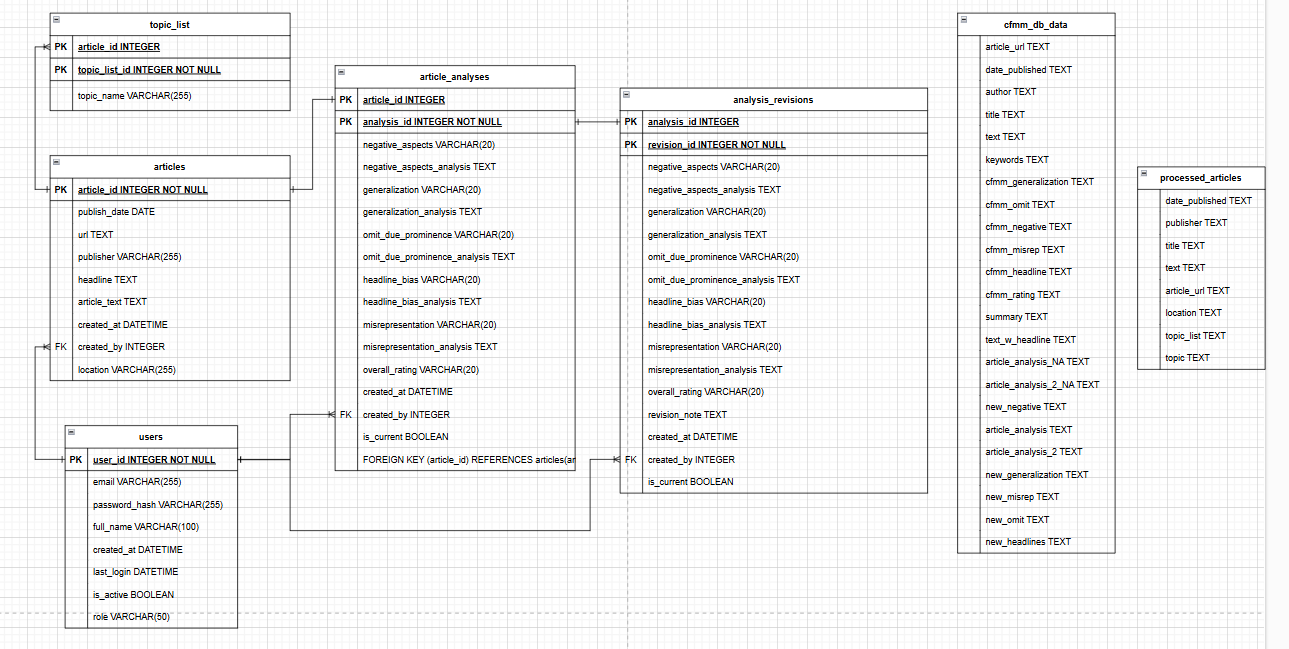